In [1]:
import os
import numpy as np
import pandas as pd
import skimage.io as skio
from datetime import datetime
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from shapely.geometry import box
from skimage.draw import polygon
from shapely import wkt

from agrobrain_image_processing.canopy.canopy import canopy_by_hsv
from agrobrain_canopy.canopy_cover.canopy_cover import CanopyCover

os.environ["NAMESPACE"]="research"
os.environ["PROFILE"]="local"
from agrobrain_util.runtime.evironment import RuntimeEnv

env = RuntimeEnv()


infestation_level_csv_path = "data/canopy_coverage/tiles_infestation_level_1000_images.csv"
output_dir = "data/canopy_coverage"
dl_project_name = "Taranis AI Annotation Projects"
dl_annotations_dataset_name = "anafa_2023_07_17_infestation_21_images"
dl_local_data_dir = "data/dataloop"

infestation_level_df = pd.read_csv(infestation_level_csv_path)

could not find stamp in environment variables
could not find stamp in environment variables
could not find KUBEFLOW_API_BASIC_AUTH_TOKEN in environment variables
could not find AI_RABBITMQ_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING in environment variables
could not find TARANIS_DB_CONNECTION_STRING in environment variables
could not find GLOBAL_DB_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING_NEW in environment variables
could not find MONGO_DB_CONNECTION_STRING in environment variables


In [2]:
# SET EXAMPLE IMAGE ATTRIBUTES
example_image_id = infestation_level_df['image_id'][0]
example_im_path = env.download_image(int(example_image_id))
example_image = skio.imread(example_im_path)
example_image_shape = example_image.shape

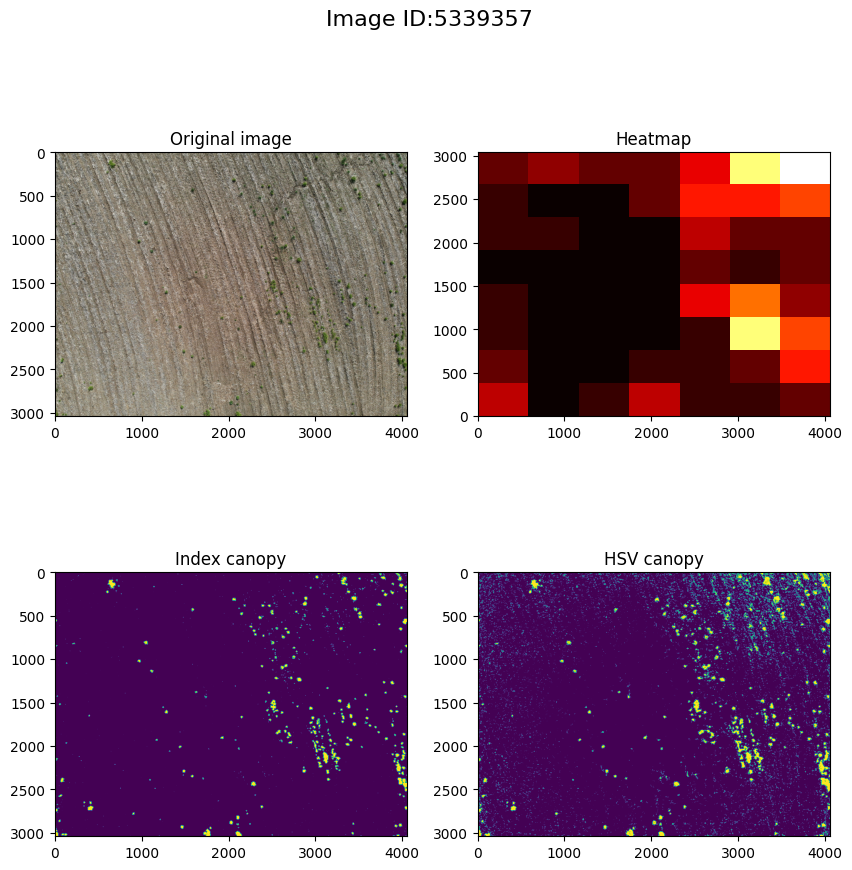

In [33]:
# CREATE IMAGE HEATMAP
image_id = np.random.choice(infestation_level_df['image_id'].values)
# image_id = 5164847
# image_id = 5372412


image_tiles_df = infestation_level_df[infestation_level_df['image_id'] == image_id]

image_path = env.download_image(int(image_id))
image = skio.imread(image_path)

index_canopy_map = CanopyCover.canopy_cover(image_path)[0].astype(np.uint8) * 255
hsv_canopy_map = canopy_by_hsv(image).astype(np.uint8) * 255


image_height, image_width, _ = example_image_shape
heatmap = np.zeros((image_height, image_width))
for coords, val in zip(image_tiles_df["box_coords"], image_tiles_df["infestation_level"]):
    coords = wkt.loads(coords)
    min_x, min_y, max_x, max_y = map(int, coords.bounds)
    heatmap[min_x:max_x, min_y:max_y] += val
    # heatmap[min_x:max_x, max_y:min_y] += val

heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# SHOW HEATMAP

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# image_plot = axes[0, 0].imshow(image, cmap='hot', interpolation='nearest', origin='lower')
image_plot = axes[0, 0].imshow(image)
axes[0, 0].set_title('Original image')

heatmap = np.flipud(heatmap)
heatmap_plot = axes[0, 1].imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower')
axes[0, 1].set_title('Heatmap')

im1_plot = axes[1, 0].imshow(index_canopy_map)
axes[1, 0].set_title('Index canopy')

im2_plot = axes[1, 1].imshow(hsv_canopy_map)
axes[1, 1].set_title('HSV canopy')


# cbar = plt.colorbar(heatmap_plot, ax=axes[0, 1])
# cbar.set_label("Infestation level")
plt.suptitle(f"Image ID:{image_id}", fontsize=16)
plt.show()

In [34]:
infestation_level_df.columns

Index(['Unnamed: 0', 'image_id', 'box_index', 'orderID',
       'image_hsv_canopy_percent', 'image_canopy_index_percent', 'box_coords',
       'hsv_canopy_percent', 'index_canopy_percent', 'canopy_cover_avg',
       'infestation_level'],
      dtype='object')

In [ ]:
# SAVE CANOPY COVER IMAGES SUBPLOTS AND HISTOGRAMS

images_ids = np.unique(infestation_level_df['image_id'].values)

canopy_images_folder = os.path.join('images', f"canopy_cover_1")
os.makedirs(canopy_images_folder, exist_ok=True)

for image_id in tqdm(images_ids):
    image_tiles_df = infestation_level_df[infestation_level_df['image_id'] == image_id].reset_index(drop=True)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
    
    # IMAGES
    image_path = env.download_image(int(image_id))
    image = skio.imread(image_path)
    index_canopy_map = CanopyCover.canopy_cover(image_path)[0].astype(np.uint8) * 255
    hsv_canopy_map = canopy_by_hsv(image).astype(np.uint8) * 255

    image_height, image_width, _ = example_image_shape
    heatmap = np.zeros((image_height, image_width))
    for coords, val in zip(image_tiles_df["box_coords"], image_tiles_df["infestation_level"]):
        coords = wkt.loads(coords)
        min_x, min_y, max_x, max_y = map(int, coords.bounds)
        heatmap[min_x:max_x, min_y:max_y] += val
        # heatmap[min_x:max_x, max_y:min_y] += val

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # image_plot = axes[0, 0].imshow(image, cmap='hot', interpolation='nearest', origin='lower')
    image_plot = axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original image')

    heatmap = np.flipud(heatmap)
    heatmap_plot = axes[2, 0].imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower')
    axes[2, 0].set_title('Heatmap')
    
    hsv_map_plot = axes[0, 1].imshow(hsv_canopy_map)
    axes[0, 1].set_title('HSV canopy')

    index_map_plot = axes[0, 2].imshow(index_canopy_map)
    axes[0, 2].set_title('Index canopy')


    
    # HISTOGRAMS

    data_lists = {"canopy_cover_avg": image_tiles_df['canopy_cover_avg'],
                  "hsv_canopy_percent": image_tiles_df['hsv_canopy_percent'],
                  "index_canopy_percent": image_tiles_df['index_canopy_percent']}
    # fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    for i in range(len(data_lists)):
        data = data_lists[list(data_lists.keys())[i]]
        axes[1, i].hist(data, bins=20, color='lightseagreen', alpha=0.7)
        axes[1, i].set_xlabel('Canopy coverage percent')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_title(list(data_lists.keys())[i])
    
    
    
    plt.suptitle(f"Image ID:{image_id}", fontsize=16)
    plt.savefig(os.path.join(canopy_images_folder, f'canopy_coverage_hist_and_heatmaps_{image_id}.jpg'))
    # plt.show()
    
    # plt.tight_layout()
    # current_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    # plt.title(image_id)
    # plt.show()
    # plt.savefig(os.path.join(canopy_images_folder, f'canopy_histograms_order_{order_id}_{current_datetime}.jpg'))

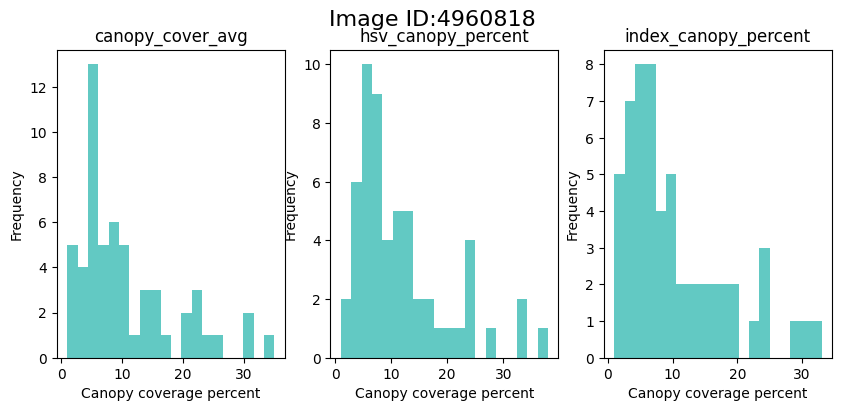

In [8]:
# HISTOGRAMS
image_df = infestation_level_df[infestation_level_df['image_id'] == image_id].reset_index(drop=True)

data_lists = {"canopy_cover_avg": image_df['canopy_cover_avg'],
                "hsv_canopy_percent": image_df['hsv_canopy_percent'],
                "index_canopy_percent": image_df['index_canopy_percent']}
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i in range(len(data_lists)):
    data = data_lists[list(data_lists.keys())[i]]
    axes[i].hist(data, bins=20, color='lightseagreen', alpha=0.7)
    axes[i].set_xlabel('Canopy coverage percent')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(list(data_lists.keys())[i])



plt.suptitle(f"Image ID:{image_id}", fontsize=16)
plt.show()